# Ini

## Imports

In [83]:
# Data
import numpy as np
import pandas as pd

# Visualization 
import matplotlib.pyplot as plt
import seaborn as sns

# Prepprc
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn import model_selection

# pipline
from sklearn.pipeline import make_pipeline, FeatureUnion, Pipeline

# ML
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer
#from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB, CategoricalNB
from sklearn.ensemble import GradientBoostingClassifier
#Metrics

from sklearn.metrics import roc_auc_score,classification_report, precision_recall_fscore_support, roc_curve, auc,accuracy_score, confusion_matrix, precision_score, log_loss, fbeta_score


## Macros

In [66]:
RSEED = 25
FIG_FOLDER = '../figures/'
FIG_SECTION = 'ModelTune'

## Utile Function 

### Save Figures

In [67]:
def save_fig(fig_name, tight_layout=True):
    path = os.path.join(FIG_FOLDER, FIG_SECTION, '_' ,fig_name + ".png")
    print("Saving figure", fig_name)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

### Model Vali Metric function 

In [107]:
def Model_Vali(m, X_train, X_test, y_train, y_test, thres=0.5):
    
    
    y_ins_pred= m.predict(X_train)
    y_outs_pred= m.predict(X_test)
    y_base = np.ones(len(X_test))
    try:
        y_ins_pred_p= m.predict_proba(X_train)[:, 1]
        y_outs_pred_p= m.predict_proba(X_test)[:, 1]
        if thres!=0.5:

            y_ins_pred = [1. if e > thres else 0. for e in y_ins_pred_p]
            y_outs_pred = [1. if e > thres else 0. for e in y_outs_pred_p]
    except:
        y_ins_pred_p= y_ins_pred
        y_outs_pred_p= y_ins_pred 
    
    print('--')
    print(f'base  precision = {precision_score(y_test, y_base)}')
    print(f'test  precision = {precision_score(y_test, y_outs_pred)}')
    print(f'train precision = {precision_score(y_train, y_ins_pred)}')
    print('--')
    print(f'base  ROC-AUC = {roc_auc_score(y_test, y_base)}')
    print(f'test  ROC-AUC = {roc_auc_score(y_test, y_outs_pred)}')
    print(f'train ROC-AUC = {roc_auc_score(y_train, y_ins_pred)}')
    print('--')
    print(f'base  accuracy = {accuracy_score(y_test, y_base)}')
    print(f'test  accuracy = {accuracy_score(y_test, y_outs_pred)}')
    print(f'train accuracy = {accuracy_score(y_train, y_ins_pred)}')
    print('--')
    #print(f'base  log_loss = {log_loss(y_test, y_base)}')
    print(f'test  log_loss = {log_loss(y_test, y_outs_pred_p)}')
    print(f'train log_loss = {log_loss(y_train, y_ins_pred_p)}')
    print('--')
    print(f'base  TNR = {TNR(y_test, y_base)}')
    print(f'test  TNR = {TNR(y_test, y_outs_pred)}')
    print(f'train TNR = {TNR(y_train, y_ins_pred)}')
    
    # log_loss
    print('--')
    cm = pd.DataFrame(confusion_matrix(y_test, y_outs_pred), 
                 index=[['actual', 'actual'], ['neg', 'pos']], 
                 columns=[['predicted', 'predicted'], ['neg', 'pos']])
    print('confusion matrix of test')
    display(cm)
    print('--')
    print(classification_report(y_test, y_outs_pred)) 
    
    base_fpr, base_tpr, base_tresh = roc_curve(y_test, y_base)
    test_fpr, test_tpr, test_tresh = roc_curve(y_test, y_outs_pred_p)
    train_fpr, train_tpr, train_tresh = roc_curve(y_train, y_ins_pred_p)
    plt.plot(base_fpr, base_tpr, 'b', label = 'baseline')
    plt.plot(test_fpr, test_tpr, 'r', label = 'model-test')
    plt.plot(train_fpr, train_tpr, 'g', label = 'model-train')
    plt.plot(train_fpr, train_tresh, 'k--', label = 'thresh')
    print(len(train_tresh))
    plt.legend();
    plt.xlabel('False Positive Rate'); 
    plt.ylabel('True Positive Rate'); plt.title('ROC Curves');
    plt.show();
    

### Search Metric

In [114]:
def pr(y_true, y_pred): 
    return precision_score(y_true, y_pred)

def fb_w(y_true, y_pred):
    return fbeta_score(y_true, y_pred, average='weighted', beta=2.0)

def fb_m(y_true, y_pred):
    return fbeta_score(y_true, y_pred, average='macro', beta=2.0)

def NPV(y_true, y_pred):
    return confusion_matrix(y_true, y_pred)[0, 0] / \
    (confusion_matrix(y_true, y_pred)[1, 0]+confusion_matrix(y_true, y_pred)[0, 0])

def TNR(y_true, y_pred):
    return confusion_matrix(y_true, y_pred)[0, 0] / \
    (confusion_matrix(y_true, y_pred)[0, 1]+confusion_matrix(y_true, y_pred)[0, 0])

def ll(y_true, y_pred):
    return log_loss(y_true, y_pred)

def special_fp(y_true, y_pred): 
    return confusion_matrix(y_true, y_pred)[1, 1] / \
    (confusion_matrix(y_true, y_pred)[0, 1]*10000+confusion_matrix(y_true, y_pred)[1, 1])

# Load Clean Data

In [70]:
df = pd.read_pickle('../data/clean_pass_01p1_PFemp_ident.pkl')

In [71]:
# some post clean
df.pub_rec_bankruptcies = df.pub_rec_bankruptcies.astype('uint8') 
#df.select_dtypes('uint8').info()

# Define the feature

In [74]:
x_col = ['addr_state',
'annual_inc',
'dti',
'emp_length',
'emp_ident' ,        
'home_ownership',
'loan_amnt',
'open_acc',
'pub_rec',
'pub_rec_bankruptcies',
'purpose',
'term',
'verification_status']
y_col = ['target']

In [75]:
df_x = df[x_col]
df_y = df[y_col]

# Encode

In [76]:
df_x_encoded = pd.get_dummies(df_x, drop_first=True)
#for i in df_x_encoded.columns:
#    print(i)
# df_x_encoded.info()

# Preprocess

## pandas pipline helper

In [77]:
from sklearn.base import BaseEstimator, TransformerMixin

class TypeSelector(BaseEstimator, TransformerMixin):
    def __init__(self, dtype):
        self.dtype = dtype

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
        return X.select_dtypes(include=[self.dtype])
    
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        assert isinstance(X, pd.DataFrame)

        try:
            return X[self.columns]
        except KeyError:
            cols_error = list(set(self.columns) - set(X.columns))
            raise KeyError("The DataFrame does not include the columns: %s" % cols_error)
            


## pipline to process

In [78]:
preprocess_pipeline = make_pipeline(
    ColumnSelector(columns=df_x_encoded.columns),
    FeatureUnion(transformer_list=[
        ("numeric_features", make_pipeline(
            TypeSelector('float64'),
            StandardScaler()
        )),
        ("bool_features", make_pipeline(
            TypeSelector('uint8'),
        )),
        #("categorical_features", make_pipeline(
        #    TypeSelector("category"),
        #    OneHotEncoder()
        #)),
    ]))

In [72]:
#Test the pre pipline
#pd.DataFrame(preprocess_pipeline.fit_transform(X_test), columns=X_test.columns ).addr_state_AL.value_counts()
#pd.DataFrame(preprocess_pipeline.fit_transform(X_test), columns=X_test.columns ).loan_amnt.max()

3.268285428818811

## Data Split Train Test

In [79]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    df_x_encoded, df_y, test_size=0.3, random_state=25, stratify=df_y)


,train,test,all
1.0,0.849514,0.849476,0.849503
0.0,0.150486,0.150524,0.150497


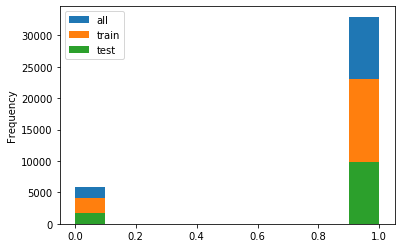

In [80]:
# check the distrbution of targets and if stratify worked
df_y.target.plot.hist()
y_train.target.plot.hist()
y_test.target.plot.hist()
plt.legend(['all','train','test'])
tts_df = pd.DataFrame()
tts_df['train'] = (y_train.target.value_counts()/y_train.shape[0])
tts_df['test'] = (y_test.target.value_counts()/y_test.shape[0])
tts_df['all'] = (df_y.target.value_counts()/df_y.shape[0])
tts_df

# Model 1 - Logistic Regression straight

--
base  precision = 0.8494762150094453
test  precision = 0.8954477914359044
train precision = 0.8970485707645829
--
base  ROC-AUC = 0.5
test  ROC-AUC = 0.6142704692635615
train ROC-AUC = 0.617766368152221
--
base  accuracy = 0.8494762150094453
test  accuracy = 0.6532715095311695
train accuracy = 0.6535036066539084
--
test  log_loss = 0.6533066025222497
train log_loss = 0.6502748458989215
--
base  TNR = 0.0
test  TNR = 0.558471192241871
train TNR = 0.5666422108094888
--
confusion matrix of test


predicted      
                 neg   pos
actual neg       979   774
       pos      3264  6629

--
              precision    recall  f1-score   support

         0.0       0.23      0.56      0.33      1753
         1.0       0.90      0.67      0.77      9893

    accuracy                           0.65     11646
   macro avg       0.56      0.61      0.55     11646
weighted avg       0.80      0.65      0.70     11646

6628


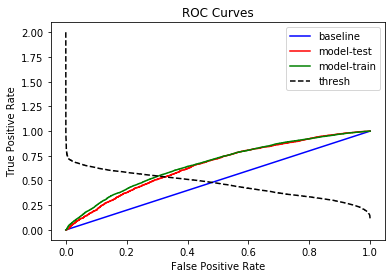

In [111]:
m1_pipline=Pipeline([('pre',preprocess_pipeline), ('M',LogisticRegression(C=0.02, class_weight='balanced' ))])
m1_pipline.fit(X_train,y_train.values.ravel())
Model_Vali(m1_pipline, X_train, X_test, y_train, y_test)

--
base  precision = 0.8494762150094453
test  precision = 0.8496821851915478
train precision = 0.8496116040201745
--
base  ROC-AUC = 0.5
test  ROC-AUC = 0.5008051351976127
train ROC-AUC = 0.50038081233049
--
base  accuracy = 0.8494762150094453
test  accuracy = 0.8496479477932337
train accuracy = 0.849477403209186
--
base  log_loss = 5.199027710336044
test  log_loss = 5.193096064141461
train log_loss = 5.198986523284524
--
base  special_fp = 0.0005640285262857647
test  special_fp = 0.0005649378077260557
train special_fp = 0.0005646259378850793
--
confusion matrix of test


predicted      
                 neg   pos
actual neg         3  1750
       pos         1  9892

--
              precision    recall  f1-score   support

         0.0       0.75      0.00      0.00      1753
         1.0       0.85      1.00      0.92      9893

    accuracy                           0.85     11646
   macro avg       0.80      0.50      0.46     11646
weighted avg       0.83      0.85      0.78     11646

6594


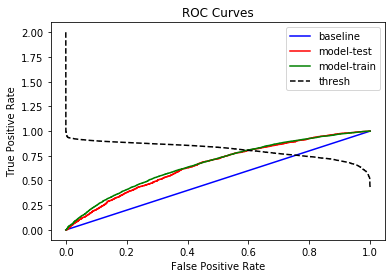

In [59]:
m1_pipline=Pipeline([('pre',preprocess_pipeline), ('M',LogisticRegression(C=0.02))])
m1_pipline.fit(X_train,y_train.values.ravel())
Model_Vali(m1_pipline, X_train, X_test, y_train, y_test)

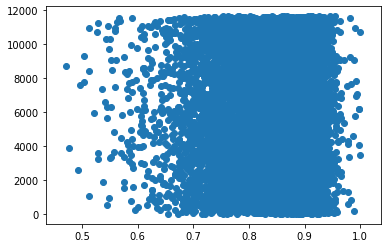

In [115]:
plt.scatter(m1_pipline.predict_proba(X_test)[:,1],range(len(X_test)))

## Grid Search - Logistic Regression - Fbeta

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   12.7s finished
/Users/arnescheunemann/opt/anaconda3/envs/nf2/lib/python3.6/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


--
base  precision = 0.8494762150094453
test  precision = 0.8503442340791738
train precision = 0.8502267615500904
--
base  ROC-AUC = 0.5
test  ROC-AUC = 0.5033866651551522
train ROC-AUC = 0.5027816776162859
--
base  accuracy = 0.8494762150094453
test  accuracy = 0.8496479477932337
train accuracy = 0.8496246135727955
--
base  log_loss = 5.199027710336044
test  log_loss = 5.193095308897451
train log_loss = 5.193901380625884
--
base  special_fp = 0.0005640285262857647
test  special_fp = 0.000567877446977942
train special_fp = 0.0005673539484318835
--
confusion matrix of test


predicted      
                 neg   pos
actual neg        14  1739
       pos        12  9881

--
              precision    recall  f1-score   support

         0.0       0.54      0.01      0.02      1753
         1.0       0.85      1.00      0.92      9893

    accuracy                           0.85     11646
   macro avg       0.69      0.50      0.47     11646
weighted avg       0.80      0.85      0.78     11646

6626


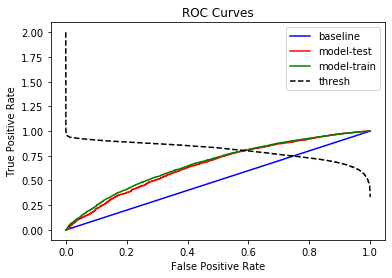

In [86]:
mg_pipline=Pipeline([('pre',preprocess_pipeline), ('M',LogisticRegression(class_weight='balanced'))])

param_grid = [
    {'M' : [LogisticRegression()],
     'M__penalty' : ['l2'],
     'M__C' : np.logspace(-4, 4, 20),
     'M__solver' : ['liblinear']}]

GSM = model_selection.GridSearchCV(
    mg_pipline, param_grid = param_grid, cv = 5, verbose=True, n_jobs=-1 ,scoring=make_scorer(fb_w))

GSM.fit(X_train,y_train)

Model_Vali(GSM, X_train, X_test, y_train, y_test)

In [ ]:
GSM.best_estimator_.get_params

## Grid Search - Logistic Regression - change metric¶

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    5.4s finished
/Users/arnescheunemann/opt/anaconda3/envs/nf2/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:1505: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
/Users/arnescheunemann/opt/anaconda3/envs/nf2/lib/python3.6/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/arnescheunemann/opt/anaconda3/envs/nf2/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://sc

--
base  precision = 0.8494762150094453
test  precision = 0.8966880196265503
train precision = 0.8998000705633306
--
base  ROC-AUC = 0.5
test  ROC-AUC = 0.6163070351909758
train ROC-AUC = 0.6230921467520523
--
base  accuracy = 0.8494762150094453
test  accuracy = 0.6503520522067663
train accuracy = 0.6509274252907404
--
base  log_loss = 5.199027710336044
test  log_loss = 12.076464328947997
train log_loss = 12.056589747524983
--
base  special_fp = 0.0005640285262857647
test  special_fp = 0.0008671892825475092
train special_fp = 0.0008971990059161661
--
confusion matrix of test


predicted      
                 neg   pos
actual neg       995   758
       pos      3314  6579

--
              precision    recall  f1-score   support

         0.0       0.23      0.57      0.33      1753
         1.0       0.90      0.67      0.76      9893

    accuracy                           0.65     11646
   macro avg       0.56      0.62      0.55     11646
weighted avg       0.80      0.65      0.70     11646

6661


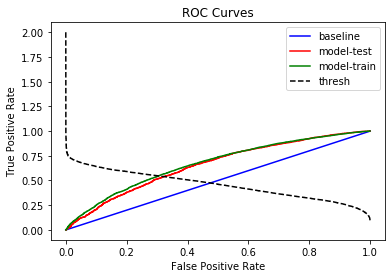

In [97]:
mg_pipline=Pipeline([('pre',preprocess_pipeline), ('M',LogisticRegression())])

param_grid = [
    {'M__penalty' : ['l2', 'elasticnet', 'none'],
     'M__C' : [0.033],
      'M__class_weight' : ['balanced', None]}] #np.logspace(-4, 4, 20)

GSM = model_selection.GridSearchCV(
    mg_pipline, param_grid = param_grid, cv = 5, verbose=True, n_jobs=-1 ,scoring= make_scorer(TNR))

GSM.fit(X_train,y_train)

Model_Vali(GSM, X_train, X_test, y_train, y_test)

# Naive Bayes

/Users/arnescheunemann/opt/anaconda3/envs/nf2/lib/python3.6/site-packages/sklearn/naive_bayes.py:206: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


--
base  precision = 0.8494762150094453
test  precision = 0.884118190212373
train precision = 0.8943954596128509
--
base  ROC-AUC = 0.5
test  ROC-AUC = 0.5637429791649933
train ROC-AUC = 0.5637429791649933
--
base  accuracy = 0.8494762150094453
test  accuracy = 0.43628713721449425
train accuracy = 0.4369203591932872
--
base  log_loss = 5.199027710336044
test  log_loss = 19.46998698527379
train log_loss = 19.448112469551585
--
confusion matrix of test


predicted      
                 neg   pos
actual neg      1251   502
       pos      6063  3830

--
              precision    recall  f1-score   support

         0.0       0.17      0.71      0.28      1753
         1.0       0.88      0.39      0.54      9893

    accuracy                           0.44     11646
   macro avg       0.53      0.55      0.41     11646
weighted avg       0.78      0.44      0.50     11646

6770


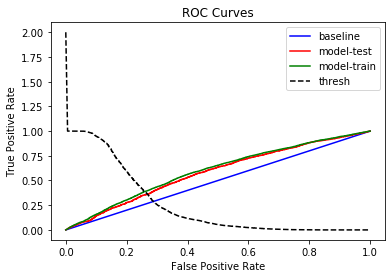

In [136]:
m2_pipline=Pipeline([('pre',preprocess_pipeline), ('M',GaussianNB())])

m2_pipline.fit(X_train,y_train)

Model_Vali(m2_pipline, X_train, X_test, y_train, y_test,0.4)

## Grid Search NB

# Bagging 

## Bagging Logistc Regression

/Users/arnescheunemann/opt/anaconda3/envs/nf2/lib/python3.6/site-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/arnescheunemann/opt/anaconda3/envs/nf2/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/arnescheunemann/opt/anaconda3/envs/nf2/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs fa

--
base  precision = 0.8494762150094453
test  precision = 0.8501031991744066
train precision = 0.849957625557316
--
base  ROC-AUC = 0.5
test  ROC-AUC = 0.5017321724583016
train ROC-AUC = 0.5017321724583016
--
base  accuracy = 0.8494762150094453
test  accuracy = 0.8496479477932337
train accuracy = 0.8495510083909907
--
base  log_loss = 5.199027710336044
test  log_loss = 5.193095583531637
train log_loss = 5.196443907814318
--
confusion matrix of test


predicted      
                 neg   pos
actual neg        10  1743
       pos         8  9885

--
              precision    recall  f1-score   support

         0.0       0.56      0.01      0.01      1753
         1.0       0.85      1.00      0.92      9893

    accuracy                           0.85     11646
   macro avg       0.70      0.50      0.46     11646
weighted avg       0.81      0.85      0.78     11646

6572


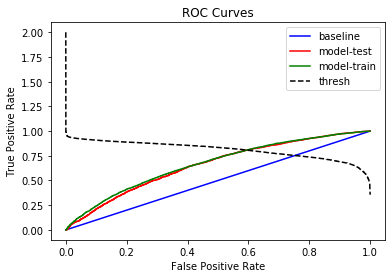

In [146]:
from sklearn.ensemble import BaggingClassifier
bagging = BaggingClassifier(LogisticRegression(),
                          max_samples=0.3, max_features=1.0,n_estimators=12)
bag_pipline=Pipeline([('pre',preprocess_pipeline),('M',bagging)])
bag_pipline.fit(X_train,y_train)
Model_Vali(bag_pipline, X_train, X_test, y_train, y_test)

# Gradient Boosting

/Users/arnescheunemann/opt/anaconda3/envs/nf2/lib/python3.6/site-packages/sklearn/ensemble/_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


--
base  precision = 0.8494762150094453
test  precision = 0.8494762150094453
train precision = 0.8495142058000883
--
base  ROC-AUC = 0.5
test  ROC-AUC = 0.5
train ROC-AUC = 0.5
--
base  accuracy = 0.8494762150094453
test  accuracy = 0.8494762150094453
train accuracy = 0.8495142058000883
--
base  log_loss = 5.199027710336044
test  log_loss = 5.199027710336044
train log_loss = 5.197715524535621
--
confusion matrix of test


predicted      
                 neg   pos
actual neg         0  1753
       pos         0  9893

--
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      1753
         1.0       0.85      1.00      0.92      9893

    accuracy                           0.85     11646
   macro avg       0.42      0.50      0.46     11646
weighted avg       0.72      0.85      0.78     11646

9109


/Users/arnescheunemann/opt/anaconda3/envs/nf2/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


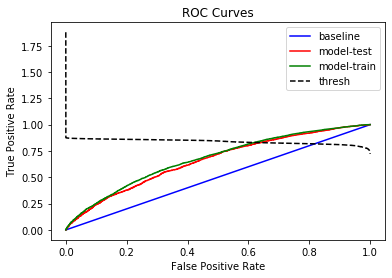

In [155]:

GBC = GradientBoostingClassifier(loss='deviance', n_estimators=100, learning_rate=0.01, max_features='sqrt')

gb_pipline=Pipeline([('pre',preprocess_pipeline),('M',GBC)])
gb_pipline.fit(X_train,y_train)
Model_Vali(gb_pipline, X_train, X_test, y_train, y_test)

## GridSearch - GB

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   12.1s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   30.1s finished
/Users/arnescheunemann/opt/anaconda3/envs/nf2/lib/python3.6/site-packages/sklearn/ensemble/_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


--
base  precision = 0.8494762150094453
test  precision = 0.8504350822779357
train precision = 0.8516057585825028
--
base  ROC-AUC = 0.5
test  ROC-AUC = 0.5081556782123677
train ROC-AUC = 0.5081556782123677
--
base  accuracy = 0.8494762150094453
test  accuracy = 0.8490468830499742
train accuracy = 0.8515751508906227
--
base  log_loss = 5.199027710336044
test  log_loss = 5.213855143688116
train log_loss = 5.126530972410723
--
confusion matrix of test


predicted      
                 neg   pos
actual neg        17  1736
       pos        22  9871

--
              precision    recall  f1-score   support

         0.0       0.44      0.01      0.02      1753
         1.0       0.85      1.00      0.92      9893

    accuracy                           0.85     11646
   macro avg       0.64      0.50      0.47     11646
weighted avg       0.79      0.85      0.78     11646

7625


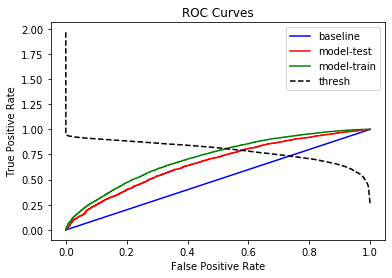

In [47]:
gb_pipline=Pipeline([('pre',preprocess_pipeline), ('M',GradientBoostingClassifier(loss='deviance'))])

param_grid = [
    {'M__n_estimators' : [10,20,40,80,100,150],
     'M__max_features' : ['sqrt', X_train.shape[1]//2 ]}] #np.logspace(-4, 4, 20)

GSM = model_selection.GridSearchCV(
    gb_pipline, param_grid = param_grid, cv = 5, verbose=True, n_jobs=-1 ,scoring= make_scorer(special_fp))

GSM.fit(X_train,y_train)

Model_Vali(GSM, X_train, X_test, y_train, y_test)

# Random Forest 

In [116]:
rf_pipline=Pipeline([('pre',preprocess_pipeline), ('M',RandomForestClassifier(random_state=RSEED, verbose=True))])

param_grid = [
    {'M__n_estimators' : [10,20,40,80,100,150],
     'M__max_depth' : [25,40,120],
     'M__class_weight': ['balanced','balanced_subsample']}] #np.logspace(-4, 4, 20)

GSM_rf = model_selection.RandomizedSearchCV(
    rf_pipline, param_grid = param_grid, cv = 5, verbose=True, n_jobs=-1 ,scoring= make_scorer(TNR))

GSM_rf.fit(X_train,y_train)

Model_Vali(GSM_rf, X_train, X_test, y_train, y_test)

TypeError: __init__() got an unexpected keyword argument 'param_grid'

In [99]:
GSM.best_estimator_.get_params

<bound method Pipeline.get_params of Pipeline(memory=None,
         steps=[('pre',
                 Pipeline(memory=None,
                          steps=[('columnselector',
                                  ColumnSelector(columns=Index(['annual_inc', 'dti', 'emp_length', 'loan_amnt', 'open_acc', 'pub_rec',
       'pub_rec_bankruptcies', 'addr_state_AL', 'addr_state_AR',
       'addr_state_AZ', 'addr_state_CA', 'addr_state_CO', 'addr_state_CT',
       'addr_state_DC', 'addr_state_DE', 'addr_state_FL', 'addr_s...
                                                                                   TypeSelector(dtype='uint8'))],
                                                                           verbose=False))],
                                               transformer_weights=None,
                                               verbose=False))],
                          verbose=False)),
                ('M',
                 LogisticRegression(C=0.033, class_weight='balanced',
  

## Random Search RF

# XG Boost

/Users/arnescheunemann/opt/anaconda3/envs/nf2/lib/python3.6/site-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/arnescheunemann/opt/anaconda3/envs/nf2/lib/python3.6/site-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


--
base  precision = 0.8494762150094453
test  precision = 0.8518776683802387
train precision = 0.8945348837209303
--
base  ROC-AUC = 0.5
test  ROC-AUC = 0.5092542111603858
train ROC-AUC = 0.6671914192456588
--
base  accuracy = 0.8494762150094453
test  accuracy = 0.8440666323201099
train accuracy = 0.8997129397909612
--
test  log_loss = 0.4202292301602023
train log_loss = 0.2326098566550585
--
base  TNR = 0.0
test  TNR = 0.030233884768967486
train TNR = 0.334556126192223
--
confusion matrix of test


predicted      
                 neg   pos
actual neg        53  1700
       pos       116  9777

--
              precision    recall  f1-score   support

         0.0       0.31      0.03      0.06      1753
         1.0       0.85      0.99      0.92      9893

    accuracy                           0.84     11646
   macro avg       0.58      0.51      0.49     11646
weighted avg       0.77      0.84      0.79     11646

2413


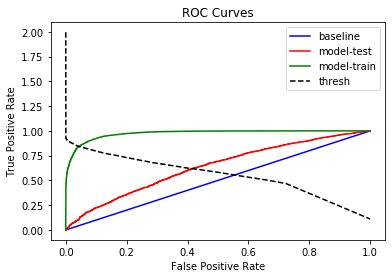

In [115]:
#https://github.com/dmlc/xgboost/blob/master/demo/guide-python/custom_objective.py
import xgboost as xgb
mxgb_pipline=Pipeline([('pre',preprocess_pipeline), 
                       ('M',xgb.XGBClassifier(objective="binary:logistic",
                            learning_rate=0.03,
                            n_estimators=500,
                            max_depth=10,
                            subsample=0.4,
                            random_state=RSEED, obj=TNR, feval=TNR))])

mxgb_pipline.fit(X_train,y_train)

Model_Vali(mxgb_pipline, X_train, X_test, y_train, y_test)

--
base  precision = 0.8494762150094453
test  precision = 0.8752153316106804
train precision = 0.9807567767601073
--
base  ROC-AUC = 0.5
test  ROC-AUC = 0.9083875463947994
train ROC-AUC = 0.9083875463947994
--
base  accuracy = 0.8494762150094453
test  accuracy = 0.7490125364932165
train accuracy = 0.9154644486971882
--
base  log_loss = 5.199027710336044
test  log_loss = 8.66887945524176
train log_loss = 2.9197667456072725
--
confusion matrix of test


predicted      
                 neg   pos
actual neg       594  1159
       pos      1764  8129

--
              precision    recall  f1-score   support

         0.0       0.25      0.34      0.29      1753
         1.0       0.88      0.82      0.85      9893

    accuracy                           0.75     11646
   macro avg       0.56      0.58      0.57     11646
weighted avg       0.78      0.75      0.76     11646

2493


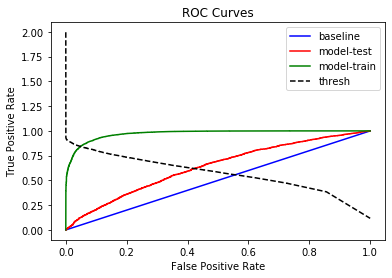

In [147]:
Model_Vali(mxgb_pipline, X_train, X_test, y_train, y_test,0.8)